### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

### Dataset download (flowers)

In [145]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [5]:
num_classes = metadata.features['label'].num_classes
num_classes

5

### Datasete image retrieving

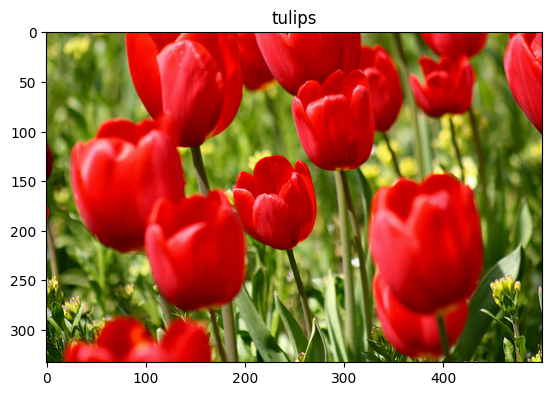

In [7]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Keras processing layers

### Resize and Rescale

In [9]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE), # resize to IMG_SIZE x IMG_SIZE
    layers.Rescaling(1./255) # rescale the pixel values from [0,255] to [0, 1]
])

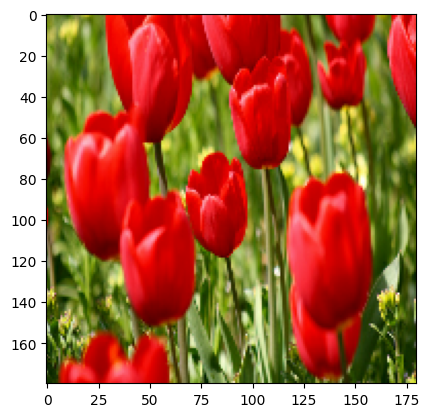

In [11]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [13]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

In [65]:
data_augmentation = tf.keras.Sequential([
    layers.Reshape((333, 500, 3)), # need to add this reshape to grant the expected shape (1, 1, 333, 500, 3)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [67]:
# add the image to a batch (batch = set or group)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

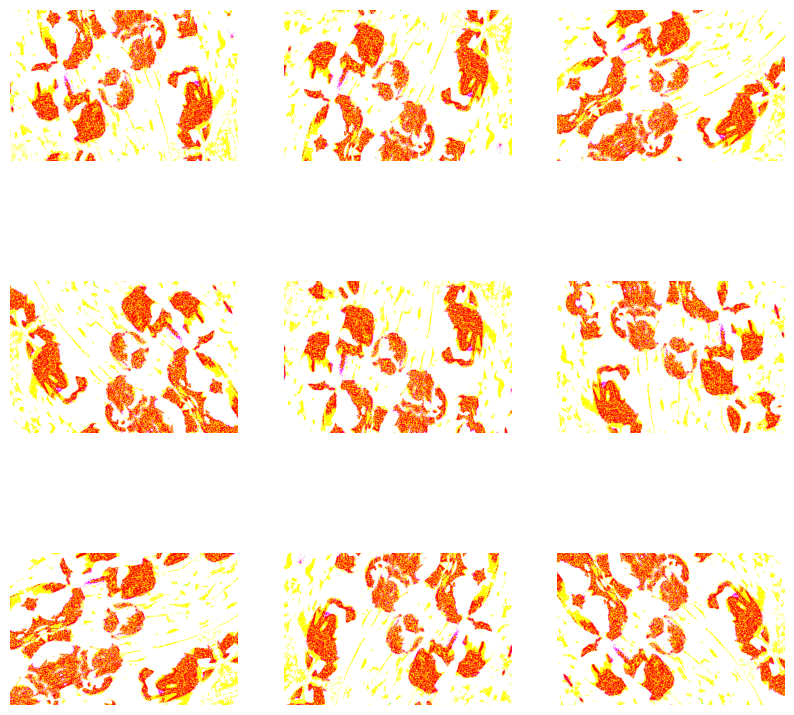

In [69]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

### Two options to use Keras processing layers

#### Make the preprocessing layers part of your model

In [75]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of your model
])

#### Apply preprocessing layers to your dataset

In [80]:
augmented_dataset = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
) 

#### Apply the preprocessing layers to the dataset

In [147]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# need to add this function to grant the expected shape (1, 1, 333, 500, 3)
def resize_and_rescale(image):
    image = tf.image.resize(image, [333, 500])  # Resize to the expected input shape
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to [0, 1]
    return image

def prepare(ds, shuffle=False, augment=False):
    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
        
    # resize and rescale all datasets
    ds = ds.map(lambda x,y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    # batch all datasets
    ds = ds.batch(batch_size)

    # use buffered prefetching on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [149]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)